### Nonlinear Independent Component Analysis: Existence and Uniqueness Results

The following notebook implements the constructions for solutions to the nonlinear independent component analysis discussed in reference [1].

Specifically, we replicate the simulations in section 4 of the paper.

[1] https://www.cs.helsinki.fi/u/ahyvarin/papers/NN99.pdf

# To do:
- ~Make the gridplot work on `f_1`, `f_2` and `f_3` as defined in `mixing_functions`~
- Move the Darmois implementation to `mixing_functions`
- Move the Box-Muller implementation to `mixing_functions`
- For scatterplots, use code from `plotting`

### Nonlinear mixings

We first define three different mixing functions

In [1]:
import numpy as np

In [2]:
from mixing_functions import f_1, f_2, f_3

In [3]:
# def f_1(x, y):
#     "Moderately nonlinear mixing"
#     f0 = np.tanh(4*x - 2) + x + y/2
#     f1 = np.tanh(4*y - 2) + y + x/2
#     return f0, f1

# def f_2(x, y):
#     "Rather nonlinear mixing"
#     f0 = np.tanh(y)/2 + x + y**2/2
#     f1 = x**3 - x + np.tanh(y)
#     return f0, f1

# def f_3(x, y):
#     "Non-bijective nonlinear mixing"
#     f0 = y**3 + x
#     f1 = np.tanh(y) + x**3
#     return f0, f1

In [4]:
from plotting import show_grid_plot

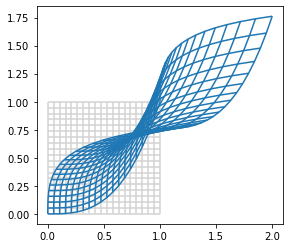

In [7]:
show_grid_plot(f_3)#, multi_argument=False)

#### Replicating figures 1, 2, 3 in the paper:

Images of a grid in the square $[0,1] \times [0,1]$ using the three functions.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

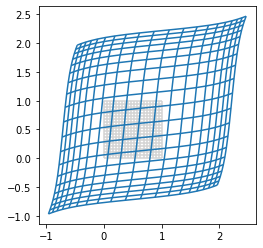

In [7]:
fig, ax = plt.subplots()

grid_x,grid_y = np.meshgrid(np.linspace(0,1,20),np.linspace(0,1,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f_1(grid_x,grid_y)
plot_grid(distx, disty, ax=ax, color="C0")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

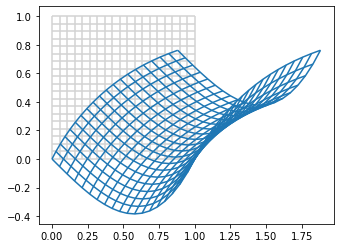

In [5]:
fig, ax = plt.subplots()

grid_x,grid_y = np.meshgrid(np.linspace(0,1,20),np.linspace(0,1,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f_2(grid_x,grid_y)
plot_grid(distx, disty, ax=ax, color="C0")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

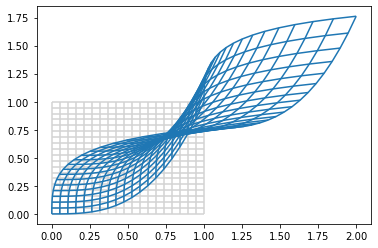

In [6]:
fig, ax = plt.subplots()

grid_x,grid_y = np.meshgrid(np.linspace(0,1,20),np.linspace(0,1,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f_3(grid_x,grid_y)
plot_grid(distx, disty, ax=ax, color="C0")

plt.show()

### The Darmois construction

For 2d data $\mathbf{X} = [X_1, X_2]$, the Darmois construction can be implemented as a vector function $\mathbf{g}=[g_1, g_2]$ s.t.
1. $g_1(\mathbf{X}) = P_{X_1}(X_1 \le x_1)$ 
2. $g_2(\mathbf{X}) = P_{X_2}(X_2 \le x_2 | Y_1 = g_1 (\mathbf{X}) = y_1 )$ 

In [7]:
from statsmodels.distributions.empirical_distribution import ECDF

In [8]:
def g_1(x):
    '''
    Takes a collection of N samples as input and returns their cdf transform
    
    Input:
    x = N dimensional array
    
    Output:
    N dimensional array
    '''
    ecdf = ECDF(x)
    return ecdf(x)

In [9]:
def g_darmois(X_0, X_1, bins_y=100):
    '''
    Takes two collections of N univariate samples (that is, N bivariate samples) as input and outputs the Darmois construction.
    Requires binning over the y_0=g_1(X_0, X_1) values in order to compute the **conditional** CDF
    
    Input:
    X_0 =  N dimensional array
    X_1 =  N dimensional array
    bins_y = n bins to discretize y_1
    
    Output:
    N dimensional array, N dimensional array
    '''    
    
    # Compute the 1st component of the estimated sources
    y_0 = g_1(X_0)

    # Create a 2d array with y_0 and X_1
    # The **third** row --- that is, arr[2,:] --- will be populated with the 2nd component of the estimated sources
    arr = np.vstack([y_0, X_1, y_0])
        
    # Establish binning for y_1
    upper_limit = np.max(y_0)
    lower_limit = np.min(y_0)
    binning = np.linspace(lower_limit, upper_limit, num=bins_y)    
    
    # Return cdf
    for i in range(bins_y-1):
        cond1 = arr[0,:]>=binning[i]
        cond2 = arr[0,:]<binning[i+1]
        and_cond = np.logical_and(cond1, cond2)
        ecdf = ECDF(arr[1, and_cond])
        arr[2, and_cond] = ecdf(arr[1, and_cond]) # select only the proper bins!

    return y_0, arr[2,:]

### Plotting the Darmois construction

In [10]:
# N:=Number of samples
N = 400
S = np.random.uniform(low=0.0, high=1.0, size=(2, N))

#### Generate sources

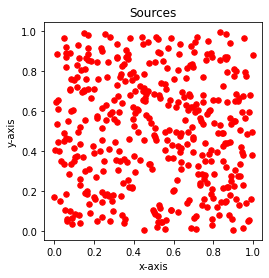

In [11]:
import matplotlib.pyplot as plt
plt.scatter(S[0], S[1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Sources')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

#### Apply mixing

In [12]:
X_0, X_1 = f_1(S[0], S[1])
# X_0, X_1 = f_2(S[0], S[1])
# X_0, X_1 = f_3(S[0], S[1])

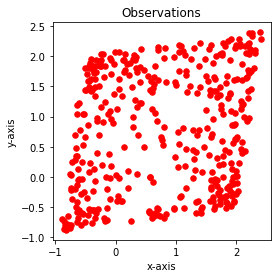

In [13]:
plt.scatter(X_0, X_1, color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Observations')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

#### Estimate sources through Darmois construction

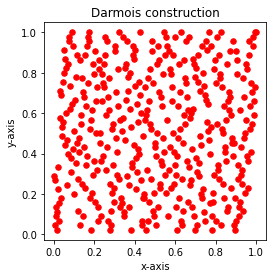

In [14]:
bins_y = 10
Y_0, Y_1 = g_darmois(X_0, X_1, bins_y=bins_y)

plt.scatter(Y_0, Y_1, color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Darmois construction')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

The plot above should replicate figure 4 of the original paper.

### Mapping onto different base distributions: composing the Darmois construction with the Box-Muller transform to get Gaussian values

In [15]:
# Box-Muller transform to turn the values into Gaussian ones

# 1. Tranform U1 to s
ss = -np.log(Y_0)

# 2. Transform U2 to theta
thetas = 2*np.pi*Y_1

# 3. Convert s to r
rs = np.sqrt(2*ss)

# 4. Calculate x and y from r and theta
xs, ys = rs*np.cos(thetas), rs*np.sin(thetas)

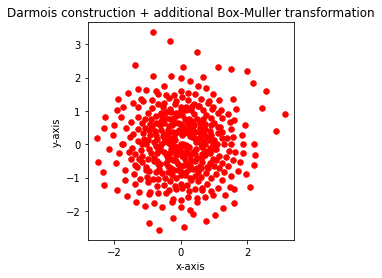

In [16]:
plt.scatter(xs, ys, color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Darmois construction + additional Box-Muller transformation')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

For comparison, a plot of the original sources under a Box-Muller transform

In [17]:
# Box-Muller transform to turn the original uniform values into Gaussian ones

# 1. Tranform U1 to s
ss = -np.log(S[0])

# 2. Transform U2 to theta
thetas = 2*np.pi*S[1]

# 3. Convert s to r
rs = np.sqrt(2*ss)

# 4. Calculate x and y from r and theta
xs, ys = rs*np.cos(thetas), rs*np.sin(thetas)

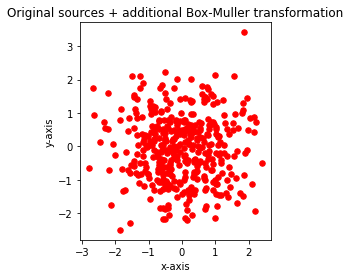

In [18]:
plt.scatter(xs, ys, color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Original sources + additional Box-Muller transformation')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()